# Exercise - Create a Text2SQL Agent - STARTER

In this exercise, you’ll build an AI agent capable of converting natural language questions into SQL queries, executing them, and returning the results.

**Scenario**

You're working on a conversational analytics assistant that allows users to query business data in plain English. Users might say things like "What was the total sales last month?" or "List the top 5 products by revenue." — and expect instant answers from your system.

However, the underlying data is stored in a relational database. To access this data, your assistant must convert the user's query into a valid SQL command. Not only that, it needs to reason about the best way to get the answer and execute the query safely.

To accomplish this, you'll use the ReAct pattern, where your agent can both think (reason step-by-step about the query) and act (run tools like a SQL engine) to solve the task.

This enables non-technical users to ask questions in plain English and get data insights without writing SQL


**Challenge**

You’re building a Text2SQL assistant for a Sales Dashboard.
The agent should:

- Parse user questions.
- Identify the relevant tables and columns.
- Generate the corresponding SQL query.
- Execute the query and return the result.

This enables non-technical users to ask questions in plain English and get data insights without writing SQL.

## 0. Import the necessary libs

In [ ]:
import os
from langchain_core.messages import SystemMessage, HumanMessage, AnyMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import MessagesState, add_messages
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from sqlalchemy import create_engine
from langchain_community.utilities import SQLDatabase
from dotenv import load_dotenv

from pydantic import BaseModel, Field
from typing import Annotated


from langchain_community.tools.sql_database.tool import (
    ListSQLDatabaseTool,
    InfoSQLDatabaseTool,
    QuerySQLDataBaseTool,
)

load_dotenv()

## 1. Instantiate Chat Model with your API Key

To be able to connect with OpenAI, you need to instantiate an ChatOpenAI client passing your OpenAI key.

You can pass the `api_key` argument directly.
```python
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
    api_key="voc-",
)
```

In [ ]:
# TODO - Instantiate your chat model
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
    base_url="https://openai.vocareum.com/v1",
    api_key=os.getenv("VOCAREUM_OPENAI_API_KEY")
)

## 2. Initialize the State Graph

You can either chose from creating it with TypedDict, Pydantic or using the MessagesState. It should store:

- user_query: The user's natural language question.
- messages: The conversation history.

In [24]:
# TODO - Instantiate your workflow passing a State Schema


class State(BaseModel):
    user_query: str = Field(default="", description="The user's natural language question.")
    messages: Annotated[list[AnyMessage], add_messages] = Field(default_factory=list)


workflow = StateGraph(State)

## 3. Define the tools available

We created the following tools:
- ListSQLDatabaseTool: Lists tables in the database., 
- InfoSQLDatabaseTool: Retrieves the schema of a specific table, 
- QuerySQLDataBaseTool: Executes the generated SQL query.

They are all accessible in the sql_toolkit.py. It's already imported. You need to add them to the tools list, then add the tools list to a node and bind the tools to the llm.

In [25]:
# TODO - create a list with the tools
db_engine = create_engine(f"sqlite:///sales.db")
db = SQLDatabase(db_engine)

In [26]:
dba_tools = [ListSQLDatabaseTool(db=db), InfoSQLDatabaseTool(db=db), QuerySQLDataBaseTool(db=db)]

In [27]:
workflow.add_node("dba_tools", ToolNode(dba_tools))

In [28]:
dba_llm = llm.bind_tools(dba_tools, tool_choice="auto")

## 4. The agent node

Before creating the dba_agent node, you need to build the initial messages to start the conversation. So, we'll first create the messages builder node.

The llm you'll use has already the tools bound to it, so the message will have a content or a tool_calls.

In [29]:
def messages_builder(state: State):
    dba_sys_msg = (
        "You are a Sr. SQL developer tasked with generating SQL queries. Perform the following steps:\n"
        "First, find out the appropriate table name based on all tables. "
        "Then get the table's schema to understand the columns. "
        "With the table name and the schema, generate the ANSI SQL query you think is applicable to the user question. "
        "Finally, use a tool to execute the above SQL query and output the result based on the user question."
    )
    messages = [
        SystemMessage(dba_sys_msg),
        HumanMessage(state.user_query)
    ]
    return {"messages": messages}

In [30]:
def dba_agent(state: State):
   ai_message = dba_llm.invoke(state.messages)
   ai_message.name = "dba_agent"
   return {"messages": ai_message}

In [31]:
# TODO - Add both nodes
workflow.add_node("messages_builder", messages_builder)
workflow.add_node("dba_agent", dba_agent)

## 5. Edges

To enable the cycle, you need to have a routing function. This function:

- Inspects the conversation history.
- Decides whether to call a tool or end the workflow.

Then, create the nodes:
- After the START entrypoint, you need to move to messages_builder
- From messages_builder, to the dba_agent
- The dba_agent should call the routing_function within a conditional edge
- If the response is a tool_call, send to dba_tools node
- Else, terminates in the END termination node.

In [32]:
# TODO - Your conditional function to route between dba_tools or END
def should_continue(state: State):
    messages = state.messages

    last_message = messages[-1]
    print(f"DEBUG - Last message type: {type(last_message)}")
    print(f"DEBUG - Has tool_calls attr: {hasattr(last_message, 
  'tool_calls')}")
    print(f"DEBUG - Tool calls value: {getattr(last_message, 
  'tool_calls', None)}")

    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
          print("DEBUG - Routing to: continue")
          return "continue"

    print("DEBUG - Routing to: end")
    return "end"

In [33]:
workflow.add_edge(START, "messages_builder")
workflow.add_edge("messages_builder", "dba_agent")
workflow.add_conditional_edges(
    source="dba_agent", 
    path=should_continue, 
    path_map={"continue": "dba_tools", "end": END}
)
workflow.add_edge("dba_tools", "dba_agent")

## 6. Compile and Run

Compile your graph, display it and run for inputs and config passed in the invoke() method.

In [34]:
react_graph = workflow.compile()

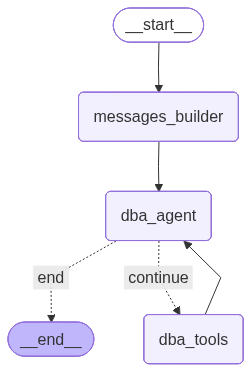

In [35]:
display(
    Image(
        react_graph.get_graph().draw_mermaid_png()
    )
)

In [36]:
db_engine = create_engine(f"sqlite:///sales.db")

In [37]:
config = {
    "configurable": {
        "db_engine": db_engine
    }
}

In [38]:
# TODO: ask the followin question:
# "How many Dell XPS 15 were sold?"
inputs = {"user_query": "How many Dell XPS 15 were sold?"}

In [39]:
# TODO: Pass input and config arguments
messages = react_graph.invoke(inputs, config)

DEBUG - Last message type: <class 'langchain_core.messages.ai.AIMessage'>
DEBUG - Has tool_calls attr: True
DEBUG - Tool calls value: [{'name': 'sql_db_list_tables', 'args': {}, 'id': 'call_Aa3p3lxGgSZ2u9LKmAXRwDhB', 'type': 'tool_call'}]
DEBUG - Routing to: continue
DEBUG - Last message type: <class 'langchain_core.messages.ai.AIMessage'>
DEBUG - Has tool_calls attr: True
DEBUG - Tool calls value: [{'name': 'sql_db_schema', 'args': {'table_names': 'sales'}, 'id': 'call_SQNolyV8OJkDPOqaM1kPaFqR', 'type': 'tool_call'}]
DEBUG - Routing to: continue
DEBUG - Last message type: <class 'langchain_core.messages.ai.AIMessage'>
DEBUG - Has tool_calls attr: True
DEBUG - Tool calls value: [{'name': 'sql_db_query', 'args': {'query': "SELECT SUM(quantity) AS total_sold FROM sales WHERE model = 'Dell XPS 15';"}, 'id': 'call_NOzNqDX2r5x2ynDTsAYvhs8N', 'type': 'tool_call'}]
DEBUG - Routing to: continue
DEBUG - Last message type: <class 'langchain_core.messages.ai.AIMessage'>
DEBUG - Has tool_calls att

In [40]:
for m in messages['messages']:
    m.pretty_print()

================================ System Message ================================

You are a Sr. SQL developer tasked with generating SQL queries. Perform the following steps:
First, find out the appropriate table name based on all tables. Then get the table's schema to understand the columns. With the table name and the schema, generate the ANSI SQL query you think is applicable to the user question. Finally, use a tool to execute the above SQL query and output the result based on the user question.
================================ Human Message =================================

How many Dell XPS 15 were sold?
================================== Ai Message ==================================
Name: dba_agent
Tool Calls:
  sql_db_list_tables (call_Aa3p3lxGgSZ2u9LKmAXRwDhB)
 Call ID: call_Aa3p3lxGgSZ2u9LKmAXRwDhB
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

sales
================================== Ai Message ============

In [42]:
print(f"Last message type: {type(messages['messages'][-1])}")
print(f"Has tool_calls: {hasattr(messages['messages'][-1], 
  'tool_calls')}")
print(f"Tool calls: {getattr(messages['messages'][-1], 'tool_calls', 
  None)}")
print(f"Content: {messages['messages'][-1].content}")


Last message type: <class 'langchain_core.messages.ai.AIMessage'>
Has tool_calls: True
Tool calls: []
Content: A total of 23 Dell XPS 15 units were sold.


## 7. Experiment

Now that you understood how it works, experiment with new things.
- Use the tools to understand what you have in the sales.db
- Ask other questions to it
- Use your own database